In [1]:
# Use the Azure Machine Learning data collector to log various metrics
from azureml.logging import get_azureml_logger
logger = get_azureml_logger()

In [2]:
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
# %azureml history on

In [3]:
# The purpose of this notebook is to apply the **Gradient Boosting** model trained using Word2Vec on testing data and show the performance of the model for sentiment polarity prediction.

import numpy as np
import pandas as pd
import os
import io

random_seed=1
np.random.seed(random_seed)

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, merge
from keras.layers.core import Lambda
from keras import optimizers
from keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Embedding , Activation
from nltk.tokenize import TweetTokenizer
import re
import num2words
from timeit import default_timer as timer
from sklearn import  metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
# Path of the test data directory'
data_dir = r'C:\Users\ds1\Documents\AzureML\data' 
vectors_file = r'../02_modeling/vectors/embeddings_Word2Vec_Basic.tsv'
model_file = r'../02_modeling/model/evaluation_word2vec_gbm'


In [5]:

# Data Preprocessing
pos_emoticons=["(^.^)","(^-^)","(^_^)","(^_~)","(^3^)","(^o^)","(~_^)","*)",":)",":*",":-*",":]",":^)",":}",
               ":>",":3",":b",":-b",":c)",":D",":-D",":O",":-O",":o)",":p",":-p",":P",":-P",":Þ",":-Þ",":X",
               ":-X",";)",";-)",";]",";D","^)","^.~","_)m"," ~.^","<=8","<3","<333","=)","=///=","=]","=^_^=",
               "=<_<=","=>.<="," =>.>="," =3","=D","=p","0-0","0w0","8D","8O","B)","C:","d'-'","d(>w<)b",":-)",
               "d^_^b","qB-)","X3","xD","XD","XP","ʘ‿ʘ","❤","💜","💚","💕","💙","💛","💓","💝","💖","💞",
               "💘","💗","😗","😘","😙","😚","😻","😀","😁","😃","☺","😄","😆","😇","😉","😊","😋","😍",
               "😎","😏","😛","😜","😝","😮","😸","😹","😺","😻","😼","👍"]

neg_emoticons=["--!--","(,_,)","(-.-)","(._.)","(;.;)9","(>.<)","(>_<)","(>_>)","(¬_¬)","(X_X)",":&",":(",":'(",
               ":-(",":-/",":-@[1]",":[",":\\",":{",":<",":-9",":c",":S",";(",";*(",";_;","^>_>^","^o)","_|_",
               "`_´","</3","<=3","=/","=\\",">:(",">:-(","💔","☹️","😌","😒","😓","😔","😕","😖","😞","😟",
               "😠","😡","😢","😣","😤","😥","😦","😧","😨","😩","😪","😫","😬","😭","😯","😰","😱","😲",
               "😳","😴","😷","😾","😿","🙀","💀","👎"]

# Emails
emailsRegex=re.compile(r'[\w\.-]+@[\w\.-]+')

# Mentions
userMentionsRegex=re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)')

#Urls
urlsRegex=re.compile('r(f|ht)(tp)(s?)(://)(.*)[.|/][^ ]+') # It may not be handling all the cases like t.co without http

#Numerics
numsRegex=re.compile(r"\b\d+\b")
punctuationNotEmoticonsRegex=re.compile(r'(?<=\w)[^\s\w](?![^\s\w])')

emoticonsDict = {} # define desired replacements here
for i,each in enumerate(pos_emoticons):
    emoticonsDict[each]=' POS_EMOTICON_'+num2words.num2words(i).upper()+' '
    
for i,each in enumerate(neg_emoticons):
    emoticonsDict[each]=' NEG_EMOTICON_'+num2words.num2words(i).upper()+' '
    
# use these three lines to do the replacement
rep = dict((re.escape(k), v) for k, v in emoticonsDict.items())
emoticonsPattern = re.compile("|".join(rep.keys()))

In [6]:

def read_data(filename):
    """Read the raw tweet data from a file. Replace Emails etc with special tokens"""
    with open(filename, 'r') as f:
    
        all_lines=f.readlines()
        padded_lines=[]
        for line in all_lines:
                    line = emoticonsPattern.sub(lambda m: rep[re.escape(m.group(0))], line.lower().strip())
                    line = userMentionsRegex.sub(' USER ', line )
                    line = emailsRegex.sub(' EMAIL ', line )
                    line=urlsRegex.sub(' URL ', line)
                    line=numsRegex.sub(' NUM ',line)
                    line=punctuationNotEmoticonsRegex.sub(' PUN ',line)
                    line=re.sub(r'(.)\1{2,}', r'\1\1',line)
                    words_tokens=[token for token in TweetTokenizer().tokenize(line)]                   
                    line= ' '.join(token for token in words_tokens )        
                    padded_lines.append(line)
        return padded_lines
    
def read_labels(filename):
    """ read the tweet labels from the file"""
    arr= np.genfromtxt(filename, delimiter='\n')
    arr[arr==4]=1 # Encode the positive category as 1
    return arr

# Convert Word Vectors to Sentence Vectors

def load_word_embedding(vectors_file):
    """ Load the word vectors"""
    vectors= np.genfromtxt(vectors_file, delimiter='\t', comments='#--#',dtype=None,
                           names=['Word']+['EV{}'.format(i) for i in range(1,51)])
    # comments have to be changed as some of the tokens are having # in them and then we dont need comments
    vectors_dc={}
    for x in vectors:
        vectors_dc[x['Word'].decode('utf-8','ignore')]=[float(x[each]) for each in ['EV{}'.format(i) for i in range(1,51)]]
    return vectors_dc

def get_sentence_embedding(text_data, vectors_dc):
    sentence_vectors=[]
    
    for sen in text_data:
        tokens=sen.split(' ')
        current_vector=np.array([vectors_dc[tokens[0]] if tokens[0] in vectors_dc else vectors_dc['<UNK>']])
        for word in tokens[1:]:
            if word in vectors_dc:
                current_vector=np.vstack([current_vector,vectors_dc[word]])
            else:
                current_vector=np.vstack([current_vector,vectors_dc['<UNK>']])
        min_max_mean=np.hstack([current_vector.min(axis=0),current_vector.max(axis=0),current_vector.mean(axis=0)])
        sentence_vectors.append(min_max_mean)
    return sentence_vectors



Step1: Loading Testing data
Step2: Load word vectors
Step 3: Convert word vectors to sentence vectors
320000 320000 320000
Step 4: Loading the model
Step 5: Getting the results
	 Accuracy : 0.6542
	 Macro-Average Precision : 0.6542
	 Macro-Average Recall : 0.6542
	 Macro-Average F1 : 0.6542
fpr [ 0.          0.          0.         ...,  0.99981882  0.99983131  1.        ], tpr [  6.25226645e-06   2.50090658e-05   3.75135987e-05 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00], auc 0.713312657288429


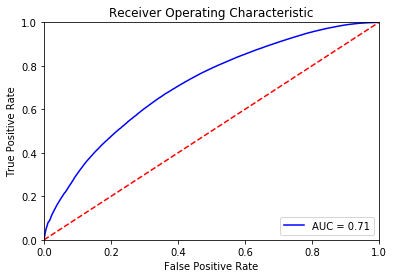

In [7]:
print ('Step1: Loading Testing data')
test_texts=read_data(data_dir+'/testing_text.csv')
test_labels=read_labels(data_dir+'/testing_label.csv')

print ('Step2: Load word vectors')
vectors_dc=load_word_embedding(vectors_file)

print ('Step 3: Convert word vectors to sentence vectors')
test_sentence_vectors=get_sentence_embedding(test_texts, vectors_dc)
print (len(test_sentence_vectors), len(test_labels), len(test_texts))
test_x=np.array(test_sentence_vectors).astype('float32')
test_y=np.array(test_labels)

print ('Step 4: Loading the model')
gbm = joblib.load(model_file)
y_pred = gbm.predict(test_x)
y_pred_pos = gbm.predict_proba(test_x)[:, 1]

print ('Step 5: Getting the results')
print ('\t Accuracy : %.4f' % metrics.accuracy_score(test_y, y_pred))
print ('\t Macro-Average Precision : %.4f' % ((metrics.precision_score(test_y, y_pred, pos_label=0) + 
                                              metrics.precision_score(test_y, y_pred, pos_label=1))/2))
print ('\t Macro-Average Recall : %.4f' % ((metrics.recall_score(test_y, y_pred, pos_label=0) + 
                                           metrics.recall_score(test_y, y_pred, pos_label=1))/2))
print ('\t Macro-Average F1 : %.4f' % ((metrics.f1_score(test_y, y_pred, pos_label=0) 
                                       + metrics.f1_score(test_y, y_pred, pos_label=1))/2)
)

fpr,tpr,thresh=metrics.roc_curve(test_y, y_pred_pos)
roc_auc=metrics.auc(fpr,tpr,'macro')
print ('fpr {}, tpr {}, auc {}'.format(fpr, tpr, roc_auc)) 

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()